# Runtime Mitosis extension 

This Colab shows the runtime of standard bipartite matching using hungarian method compared to matching with our mitosis-extension. The experiment demonstrates how our extension influences the computational burden of MHT trackers.

The setup is done as follows: A standard matching is done with a cost matrix $C$ that has the size $J\times(I+J)$ with J new detections and I old objects from the subsequent frame. A cost value reflects the log-likelihood and a row can at maximum contain a cumulated sum of likelihoods $\leq 1$. The right $J\times J$ submatrix is an eye matrix with values other that 0 only on the diagonal. As described in the paper, the matching matrix $C$ is extended (in this file denote it as $C_\text{M}$) that is $J\times(2I+J)$ to allow mitosis.

We conduct experiments by randomly creating matrices $C$ of different sizes that hold the above described restrictions. Then we extend $C$ to $C_\text{M}$ and solve the bipartite matching problem with the hungarian method on both matrices. We repeat the calculations 1000 times with different initializations to reduce noise and plot the runtimes.


In [1]:
import numpy as np
from  scipy.optimize import linear_sum_assignment as hungarian
from datetime import datetime

now = datetime.now

def create_matrices(size):
  # Create costs
  c_jj = np.random.rand(size, size)
  c_ji = np.eye(size) * np.random.rand(size, 1)
  # Normalize
  sum_of_both = np.sum(c_jj, axis=1, keepdims=True) + np.sum(c_ji, axis=1, keepdims=True)
  c_jj = c_jj / sum_of_both
  c_ji = c_ji / sum_of_both
  # Concatenate
  C = np.concatenate([c_jj, c_ji], axis=1)
  C_M = np.concatenate([c_jj, c_jj, c_ji], axis=1)
  C = -np.log(C)
  C_M_inf = -np.log(C_M)
  C_M_inf[:, size:2*size] = np.inf
  C_M = -np.log(C_M)
  return C, C_M, C_M_inf

sizes = []
runtimes_c = []
runtimes_c_m = []
runtimes_c_m_inf = []


for size in range(2, 100):
  matrices = [create_matrices(size) for x in range(2000)]
  t_c_start = now()
  for C, C_M, C_M_inf in matrices:
    hungarian(C)
  t_c = (now() - t_c_start)
  t_c_m_start = now()
  for C, C_M, C_M_inf in matrices:
    hungarian(C_M)
  t_c_m = (now() - t_c_m_start)
  t_c_m_inf_start = now()
  for C, C_M, C_M_inf in matrices:
    hungarian(C_M_inf)
  t_c_m_inf = (now() - t_c_m_inf_start)
  sizes.append(size)
  runtimes_c.append(t_c)
  runtimes_c_m.append(t_c_m)
  runtimes_c_m_inf.append(t_c_m_inf)
  print("Size", size, "Time C", t_c, "Time C_M", t_c_m, "Time C_M_inf", t_c_m_inf, "Shapes", C.shape, C_M.shape)


C:\Users\kaiser\AppData\Local\Temp\ipykernel_23340\2659564513.py:18: RuntimeWarning: divide by zero encountered in log
  C = -np.log(C)
C:\Users\kaiser\AppData\Local\Temp\ipykernel_23340\2659564513.py:19: RuntimeWarning: divide by zero encountered in log
  C_M_inf = -np.log(C_M)
C:\Users\kaiser\AppData\Local\Temp\ipykernel_23340\2659564513.py:21: RuntimeWarning: divide by zero encountered in log
  C_M = -np.log(C_M)


Size 2 Time C 0:00:00.004001 Time C_M 0:00:00.003000 Time C_M_inf 0:00:00.002998 Shapes (2, 4) (2, 6)
Size 3 Time C 0:00:00.002001 Time C_M 0:00:00.003001 Time C_M_inf 0:00:00.003996 Shapes (3, 6) (3, 9)
Size 4 Time C 0:00:00.003001 Time C_M 0:00:00.002998 Time C_M_inf 0:00:00.003999 Shapes (4, 8) (4, 12)
Size 5 Time C 0:00:00.005014 Time C_M 0:00:00.005001 Time C_M_inf 0:00:00.003986 Shapes (5, 10) (5, 15)
Size 6 Time C 0:00:00.004999 Time C_M 0:00:00.004001 Time C_M_inf 0:00:00.008007 Shapes (6, 12) (6, 18)
Size 7 Time C 0:00:00.004992 Time C_M 0:00:00.006000 Time C_M_inf 0:00:00.007001 Shapes (7, 14) (7, 21)
Size 8 Time C 0:00:00.006973 Time C_M 0:00:00.007001 Time C_M_inf 0:00:00.007999 Shapes (8, 16) (8, 24)
Size 9 Time C 0:00:00.008995 Time C_M 0:00:00.008996 Time C_M_inf 0:00:00.010996 Shapes (9, 18) (9, 27)
Size 10 Time C 0:00:00.008999 Time C_M 0:00:00.007998 Time C_M_inf 0:00:00.011000 Shapes (10, 20) (10, 30)
Size 11 Time C 0:00:00.012002 Time C_M 0:00:00.011000 Time C_M_inf

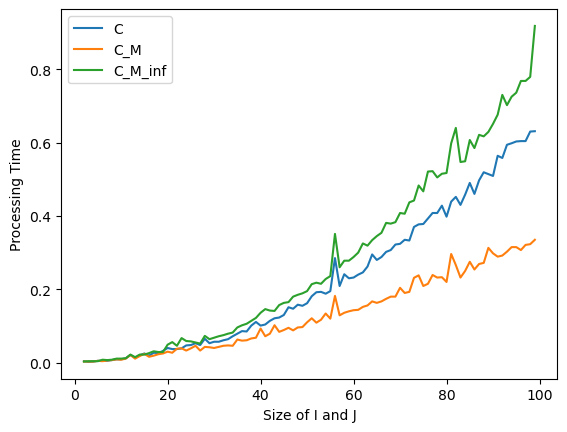

In [2]:
import matplotlib.pyplot as plt

sizes = np.asarray(sizes)
runtimes_c_converted = np.asarray([x.total_seconds() for x in runtimes_c])
runtimes_c_m_converted = np.asarray([x.total_seconds() for x in runtimes_c_m])
runtimes_c_m_inf_converted = np.asarray([x.total_seconds() for x in runtimes_c_m_inf])

# plot lines
plt.plot(sizes, runtimes_c_converted, label = "C")
plt.plot(sizes, runtimes_c_m_converted, label = "C_M")
plt.plot(sizes, runtimes_c_m_inf_converted, label = "C_M_inf")
plt.legend()
plt.xlabel("Size of I and J")
plt.ylabel("Processing Time")
plt.show()

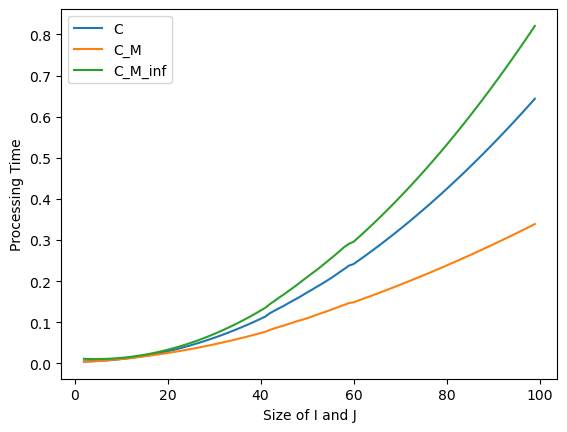

In [3]:
from scipy.signal import savgol_filter


runtimes_c_converted = savgol_filter(runtimes_c_converted, 80, 2)
runtimes_c_m_converted = savgol_filter(runtimes_c_m_converted, 80, 2)
runtimes_c_m_inf_converted = savgol_filter(runtimes_c_m_inf_converted, 80, 2)

# plot lines
plt.plot(sizes, runtimes_c_converted, label = "C")
plt.plot(sizes, runtimes_c_m_converted, label = "C_M")
plt.plot(sizes, runtimes_c_m_inf_converted, label = "C_M_inf")
plt.legend()
plt.xlabel("Size of I and J")
plt.ylabel("Processing Time")
plt.show()

In [4]:
print(f"sizes,runtimes_c,runtimes_c_m,runtimes_c_m_inf")
for i, c, cm, cm_inf in zip(sizes, runtimes_c_converted, runtimes_c_m_converted, runtimes_c_m_inf_converted):
  print(f"{i},{c},{cm},{cm_inf}")
  


sizes,runtimes_c,runtimes_c_m
2,0.0050612825993676565,0.0037301616757000823,0.011222475158084928
3,0.005274996942500539,0.00439231261734874,0.0108661085497353
4,0.005624407549846551,0.005118419256299421,0.010695929873101083
5,0.0061095144214056915,0.005908481592552126,0.010711939128182274
6,0.0067303175571779604,0.006762499626106852,0.010914136314978874
7,0.007486816957163359,0.007680473356963603,0.011302521433490883
8,0.008379012621361887,0.008662402785122376,0.011877094483718303
9,0.009406904549773543,0.009708287910583176,0.012637855465661131
10,0.010570492742398328,0.010818128733345995,0.013584804379319368
11,0.011869777199236244,0.01199192525341084,0.014717941224693016
12,0.013304757920287286,0.013229677470777705,0.016037266001782072
13,0.014875434905551458,0.014531385385446597,0.017542778710586536
14,0.01658180815502876,0.01589704899741751,0.019234479351106414
15,0.01842387766871919,0.01732666830669045,0.021112367923341695
16,0.02040164344662275,0.01882024331326541,0.0231764444272